# Face Identification

Writing function to load the images from image-paths

In [1]:
import numpy as np
from PIL import Image

# Function to load images from file-paths
def load_imgs(file_paths, slice_, color, resize):
    default_slice = (slice(0, 250), slice(0, 250))  # Setting the default slice to the size of original dataset i.e., 250x250

    if slice_ is None: slice_ = default_slice
    else: slice_ = tuple(s or ds for s, ds in zip(slice_, default_slice))

    # Obtain the height and width of the image from slice
    h_slice, w_slice = slice_
    h = (h_slice.stop - h_slice.start) // (h_slice.step or 1)
    w = (w_slice.stop - w_slice.start) // (w_slice.step or 1)

    # Resizing the image
    if resize is not None:
        resize = float(resize)
        h = int(resize * h)
        w = int(resize * w)
        
    # Setting the dimensions for each image
    n_faces = len(file_paths)
    if not color: faces = np.zeros((n_faces, h, w), dtype=np.float32)
    else: faces = np.zeros((n_faces, h, w, 3), dtype=np.float32)

    # Loading images
    for i, file_path in enumerate(file_paths):
        pil_img = Image.open(file_path)
        pil_img = pil_img.crop((w_slice.start, h_slice.start, w_slice.stop, h_slice.stop))

        if resize is not None: pil_img = pil_img.resize((w, h))
        face = np.asarray(pil_img, dtype=np.float32)

        face /= 255.0
        if not color: face = face.mean(axis=2)
        faces[i, ...] = face

    return faces

Writing function to fetch image paths and return corresponding images (using `load_imgs` function written above)

In [2]:
from os import listdir
from os.path import join, isdir

# Function to fetch and load images from a certain directory
def fetch_lfw_deep_people(data_folder_path, slice_=None, color=False, resize=None, min_faces_per_person=0):
    person_names, file_paths = [], []

    # Fetching the names of the people and file paths
    for person_name in sorted(listdir(data_folder_path)):
        folder_path = join(data_folder_path, person_name)
        if not isdir(folder_path): continue

        paths = [join(folder_path, f) for f in sorted(listdir(folder_path))]
        n_pictures = len(paths)
        if n_pictures >= min_faces_per_person:
            person_name = person_name.replace("_", " ")
            person_names.extend([person_name] * n_pictures)
            file_paths.extend(paths)

    n_faces = len(file_paths)
    if n_faces == 0: raise ValueError("min_faces_per_person=%d is too restrictive" % min_faces_per_person)

    target_names = np.unique(person_names)
    target = np.searchsorted(target_names, person_names)
    file_paths = np.array(file_paths)

    # Loading the images of the found file-paths
    faces = load_imgs(file_paths, slice_, color, resize)

    indices = np.arange(n_faces)
    np.random.RandomState(42).shuffle(indices)
    faces, target, paths = faces[indices], target[indices], file_paths[indices]
    return faces, target, target_names, paths

Function to compute HoG features

In [3]:
from skimage.feature import hog
from skimage.io import imread

# Function to compute HoG features (already provided)
def compute_hog(img):
  image = imread(img)
  fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
  return fd, hog_image

Functions to calculate LBP features

In [4]:
import cv2
import numpy as np

# Functions to calculate LBP features (already provided)
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val


def calcLBP(image):
    img = imread(image)
    height, width, channel = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return hist_lbp

Function to extract CNN features

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()

# Define a function to extract features from an image
def extract_cnn_features(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    # Add batch dimension
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = model(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    return features

/home/nazam/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nazam/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading the Dataset

(1867, 100, 100) (1867,) (19,)


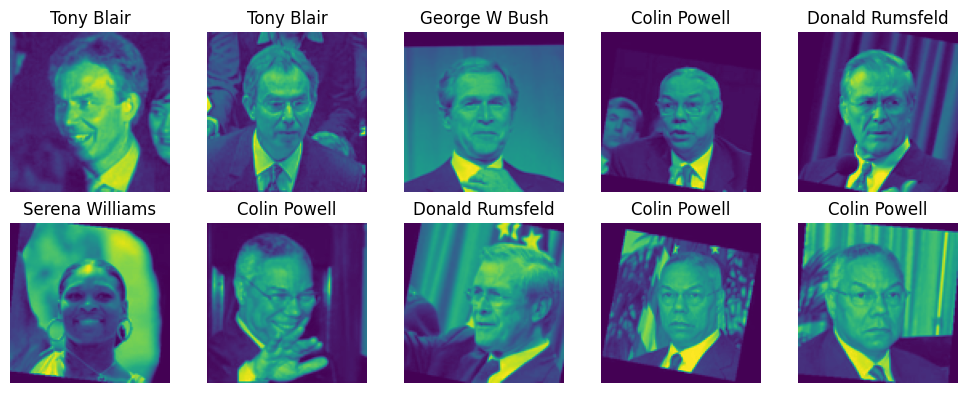

In [6]:
import matplotlib.pyplot as plt
DATA_DIR = "../Dataset/lfw-deepfunneled/lfw-deepfunneled"   # Directory containing all the images

# Calling the function to fetch and load images
faces, target, target_names, paths = fetch_lfw_deep_people(DATA_DIR, resize=0.4, min_faces_per_person=40)

print(faces.shape, target.shape, target_names.shape)
h = faces.shape[1]
w = faces.shape[2]

# Plotting the faces
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(faces[i])
    plt.title(target_names[target[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

Extracting the HoG features

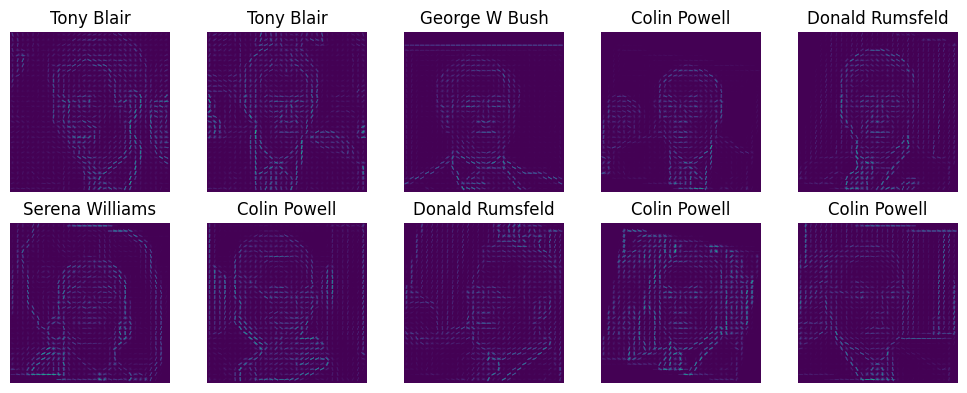

In [7]:
# Plotting HoG features
plt.figure(figsize=(10, 4))
for i in range(10):
    hog_f, hog_i = compute_hog(paths[i])
    plt.subplot(2, 5, i + 1)
    plt.imshow(hog_i)
    plt.title(target_names[target[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

Extracting the LBP features

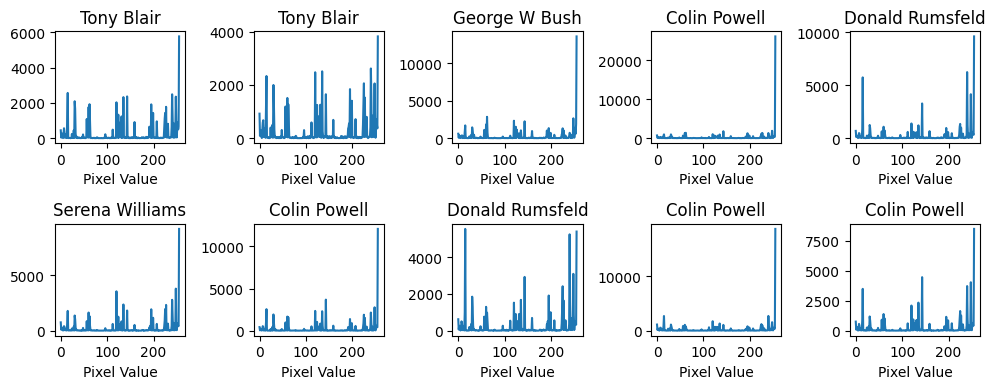

In [8]:
# Plotting the histograms for LBP Features
plt.figure(figsize=(10, 4))
for i in range(10):
    hist_lbp = calcLBP(paths[i])
    plt.subplot(2, 5, i + 1)
    plt.plot(hist_lbp)
    plt.title(target_names[target[i]])
    plt.xlabel("Pixel Value")
plt.tight_layout()
plt.show()

Extracting the CNN features

In [9]:
feats = extract_cnn_features(paths[0], resnet)
print(f"CNN features for {paths[0]}:")
print(feats)

CNN features for ../Dataset/lfw-deepfunneled/lfw-deepfunneled/Tony_Blair/Tony_Blair_0060.jpg:
tensor([[[0.0816]],

        [[1.4376]],

        [[0.4798]],

        ...,

        [[0.0092]],

        [[0.0562]],

        [[0.0458]]])


80-20 Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

# Storing faces as 1-D array
X = faces.reshape(len(faces), -1)
y = target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Getting the train and test indices
train_indices = np.arange(len(X))[~np.isin(np.arange(len(X)), np.arange(len(X_test)))]
test_indices = np.arange(len(X))[np.isin(np.arange(len(X)), np.arange(len(X_test)))]

Principle Component Analysis for the model: finding the optimal `n_components`

In [11]:
from sklearn.decomposition import PCA

# Fitting data to PCA model
pca = PCA()
pca.fit(X_train)

# Cummulative Variance Ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

Setting the `n_components` to incorporate 98% of the total variance

n_components = 606


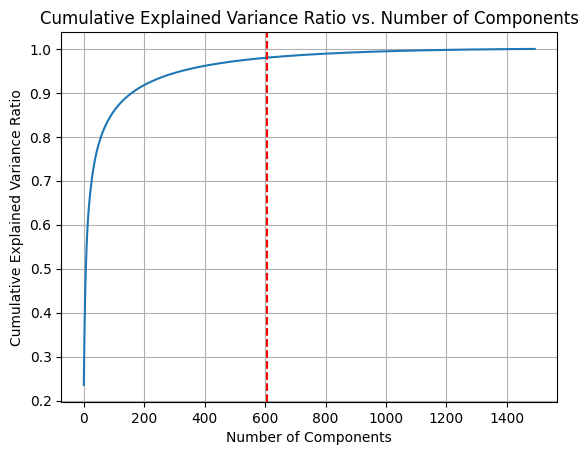

In [12]:
# Setting the total variance and n_components
target_variance = 0.98
n_comp = np.argmax(cumulative_variance_ratio >= target_variance) + 1

print(f"n_components = {n_comp}")

# Plotting the cummulative variance ratio with n_components
plt.plot(cumulative_variance_ratio)
plt.axvline(x=n_comp, color='red', linestyle='--', label='n_components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

Transforming the dataset to first `n_components` principle components (eigenfaces)

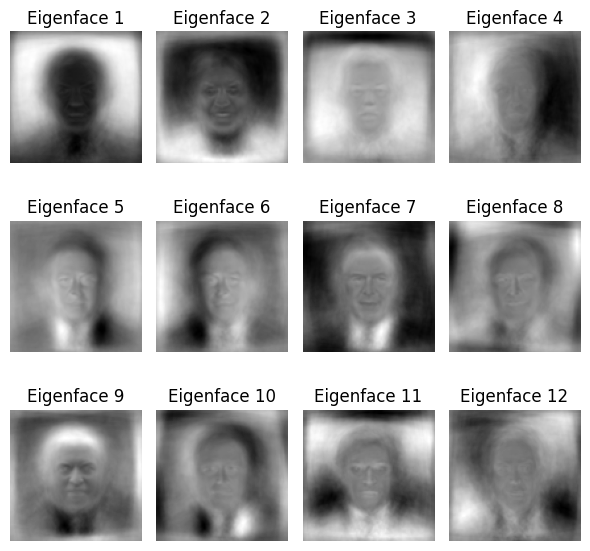

In [13]:
# Calling another instance of PCA with n_components = n_com
pca = PCA(n_comp)
pca.fit(X_train)

# Transforming the dataset to n_comp dimensions
X_train_t = pca.transform(X_train)
X_test_t = pca.transform(X_test)

fig, axes = plt.subplots(3, 4, figsize=(6, 6))

# plotting first 12 eigenfaces
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape((h, w)), cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Applying LDA to the dataset

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Fitting the dataset to LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_t, y_train)

# Printing the LDA projection vector
print(f"LDA Projection Vector: {lda.coef_[0]}")

# Transforming the dataset along the LDA projection vector
X_train_t = lda.transform(X_train_t)
X_test_t = lda.transform(X_test_t)

LDA Projection Vector: [-9.24108252e-02 -8.51378441e-01  5.10502309e-02  2.09138826e-01
 -8.71863186e-01 -4.91712987e-01  2.96666294e-01 -6.31462812e-01
  1.57300460e+00 -2.53497005e-01  4.31331128e-01  2.75186360e-01
  9.05099750e-01  7.33422339e-01 -5.57693131e-02  1.27192461e+00
 -6.36332035e-01 -8.44200626e-02  4.31722403e-01 -3.00695091e-01
  4.49751198e-01 -1.60216615e-02  3.91667672e-02  1.94420725e-01
  3.34689289e-01 -1.89373150e-01 -2.60609329e-01  3.74837041e-01
 -4.14387792e-01 -8.22220564e-01 -1.12758768e+00  8.00254703e-01
 -1.49644315e-01  3.20564248e-02  6.23170674e-01 -2.67682999e-01
  1.31764323e-01 -2.47477695e-01  7.10702896e-01 -4.28711623e-01
 -9.75518048e-01 -6.51634216e-01 -1.06261098e+00 -8.54634583e-01
  8.80027473e-01 -1.10679519e+00  1.11772549e+00  9.06577483e-02
 -5.04324019e-01 -5.37154973e-02 -1.72977209e-01  1.44391465e+00
  6.66382015e-01 -1.23110318e+00  1.67742837e-02 -7.89838016e-01
  7.92122073e-03 -3.82789135e-01 -3.78296375e-01  2.78700292e-01
 -

Writing the transformed data into csv for easy accessibility

In [25]:
# Writing the transformed dataset into csv files for easy accessibility
with open("./test.csv", "w") as f:
    for i in range(X_test_t.shape[0]):
        for j in range(X_test_t.shape[1]):
            f.write(f"{X_test_t[i][j]},")
        f.write(f"{y_test[i]}\n")

with open("./train.csv", "w") as f:
    for i in range(X_train_t.shape[0]):
        for j in range(X_train_t.shape[1]):
            f.write(f"{X_train_t[i][j]},")
        f.write(f"{y_train[i]}\n")

print(f"Dimensions of transformed data: {X_train_t.shape[1]}")

Dimensions of transformed data: 18


Applying various ML models to make predictions on `X_test`\
Models:
- Naive Bayes
- K-Nearest Neighbors
- Random Forest Classifier
- Support Vector Classifier with Linear Kernel

In [22]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Reading the test and train files to load the transformed dataset in form of DataFrames
df = pd.read_csv("./train.csv", header=None)
X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1]

df = pd.read_csv("./test.csv", header=None)
X_test = df.iloc[:, :-1]
y_test = df.iloc[:, -1]

# Naive Bayes Classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f"Accuracy for Naive Bayes Classifier: {np.mean(gnb.predict(X_test) == y_test)*100:.2f}%")

# K-Nearest neighbors classifier with k = 5
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)
print(f"Accuracy for K-Nearest Neighbor Classifier: {np.mean(knn.predict(X_test) == y_test)*100:.2f}%")

# Random Forets Classifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
print(f"Accuracy for Random Forest Classifier: {np.mean(forest.predict(X_test) == y_test)*100:.2f}%")

# Support Vector Classifier with linear kernel
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
print(f"Accuracy for Support Vector Classifier with linear kernel = {np.mean(svm.predict(X_test) == y_test)*100:.2f}%")

Accuracy for Naive Bayes Classifier: 82.09%
Accuracy for K-Nearest Neighbor Classifier: 79.14%
Accuracy for Random Forest Classifier: 78.61%
Accuracy for Support Vector Classifier with linear kernel = 76.74%


Converting the train and test data to tensors

In [18]:
import torch

# Converting the train and test data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.int64))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.int64))

Training an Artificial Neural Network on the transformed dataset

In [28]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# ANN class
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        # defining the sequence of layers
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], 200),
            nn.ReLU(),  # ReLU activation in each hidden layer
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, y_train.unique().shape[0])
        )
    # Forwarding the input to the layers
    def forward(self, x):
        logits = self.layers(x)
        return logits
    
# Defining train dataset and train loader for batch size of 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Calling the model
model = ANN()
criterion = nn.CrossEntropyLoss()   # Cross Entropy Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)    # Adam optimizer

# training the model for 20 epochs
for epoch in range(20):
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{20}], Loss: {loss.item()}")

Epoch [1/20], Loss: 0.07054485380649567
Epoch [2/20], Loss: 0.006502165459096432
Epoch [3/20], Loss: 0.0007349259103648365
Epoch [4/20], Loss: 0.001954293344169855
Epoch [5/20], Loss: 0.00036048420588485897
Epoch [6/20], Loss: 0.0020740737672895193
Epoch [7/20], Loss: 0.00036407538573257625
Epoch [8/20], Loss: 7.203712448244914e-05
Epoch [9/20], Loss: 0.00038455723552033305
Epoch [10/20], Loss: 1.5997333321138285e-05
Epoch [11/20], Loss: 8.225348210544325e-06
Epoch [12/20], Loss: 5.43591522728093e-06
Epoch [13/20], Loss: 1.0180216122535057e-05
Epoch [14/20], Loss: 5.7666748034534976e-05
Epoch [15/20], Loss: 7.200149411801249e-06
Epoch [16/20], Loss: 0.00011775737948482856
Epoch [17/20], Loss: 9.041205339599401e-05
Epoch [18/20], Loss: 0.00031073015998117626
Epoch [19/20], Loss: 5.232756302575581e-05
Epoch [20/20], Loss: 0.000970624212641269


Evaluating the trained Neural Network

In [29]:
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)  # Predictions for test data
    probabilities = nn.functional.softmax(outputs, dim=1)   # Applying softmax activation for output layer
    _, predicted = torch.max(probabilities, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)   # Computing accuracy of the model
    print(f"Accuracy for Neural Network with Cross Entropy Loss as Loss function = {accuracy*100:.2f}%")

Accuracy for Neural Network with Cross Entropy Loss as Loss function = 77.81%
